# A survival analysis on US divorced couples

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Loading and Understanding Dataset

In [3]:
df = pd.read_stata('divorce.dta')
df.head()

,id,heduc,heblack,mixed,years,div
0,9.0,12-15 years,No,No,10.546000,No
1,11.0,< 12 years,No,No,34.943001,No
2,13.0,< 12 years,No,No,2.834000,Yes
3,15.0,< 12 years,No,No,17.532000,Yes
4,33.0,12-15 years,No,No,1.418000,No


In [4]:
df.shape

(3371, 6)

The data is based on a survey conducted in the US.
The event of interest is the divorce among couples in the US.
The dataset comprises 3371 couples with the following information:
- **heduc**: education level of the husband
less than 12 years (count 1288/3371)
12 to 15 years (count 1655/3371)
16 or more years (count 428/3371)

- **heblack**: if the husband is black or not
black (count 745/3371)
not black (count 2626/3371)

- **mixed**: if the couple has mixed ethnicity
mixed couple (count 641/3371)
otherwise (count 2730/3371)

- **years**: duration of the marriage, from wedding to divorce

- **div**: event (ie divorce) indicator
1 = divorced (count 1032/3371)
0 for censoring (count 2339/3371)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3371 entries, 0 to 3370
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3371 non-null   float32 
 1   heduc    3371 non-null   category
 2   heblack  3371 non-null   category
 3   mixed    3371 non-null   category
 4   years    3371 non-null   float32 
 5   div      3371 non-null   category
dtypes: category(4), float32(2)
memory usage: 66.3 KB


# 2. Preprocessing

### Encoding ordinal features

In [6]:
# label encode education
def Hed_LabelEncoder(text):
    if text == '< 12 years':
        return 0
    elif text == '12-15 years':
        return 1
    elif text == "16+ years":
        return 2

df["heduc"] = df["heduc"].apply(Hed_LabelEncoder)
df.head()

,id,heduc,heblack,mixed,years,div
0,9.0,1,No,No,10.546000,No
1,11.0,0,No,No,34.943001,No
2,13.0,0,No,No,2.834000,Yes
3,15.0,0,No,No,17.532000,Yes
4,33.0,1,No,No,1.418000,No


### Dummy variables for categorical features

In [7]:
df = pd.get_dummies(df, drop_first = True, columns = ['heblack', 'mixed','div'])
df.head()

,id,heduc,years,heblack_Yes,mixed_Yes,div_Yes
0,9.0,1,10.546000,0,0,0
1,11.0,0,34.943001,0,0,0
2,13.0,0,2.834000,0,0,1
3,15.0,0,17.532000,0,0,1
4,33.0,1,1.418000,0,0,0


In [8]:
# renaming columns
df=df.rename(columns={'years':'time',"div_Yes": "event", "heblack_Yes": "he_black", "mixed_Yes":"mixed_couple"})

In [9]:
df.head()

,id,heduc,time,he_black,mixed_couple,event
0,9.0,1,10.546000,0,0,0
1,11.0,0,34.943001,0,0,0
2,13.0,0,2.834000,0,0,1
3,15.0,0,17.532000,0,0,1
4,33.0,1,1.418000,0,0,0


# 3. Data analysis and visualization

**Time vs Event**

In [10]:
df['event'].value_counts()

0    2339
1    1032
Name: event, dtype: int64

In [11]:
print(df["time"].max())
print(df["time"].min())
print(df["time"].mean())
print(df["time"].median())

73.06800079345703
0.07900000363588333
18.41009
14.496999740600586


In principle, they are not related to the divorce event: all the couples who reported a marriage
duration lower than 14,49 years (50% of the sample size) may or may not have divorced.
To figure this out, we can get the number of divorces (event=1) among these first 50%:

In [12]:
# Shuffle dataframe using sample function
df = df.sample(frac=1)

# Select ratio
ratio = 0.50
  
total_rows = df.shape[0]
subset_size = int(total_rows*ratio)
  
# create subset
sub_df = df[0:subset_size]
sub_df.shape

(1685, 6)

In [13]:
# analyzing the proportion of divorced couples on 50% of population
sub_df['event'].value_counts()

0    1176
1     509
Name: event, dtype: int64

out of 1685 couples, we get 509 divorced and 1176 not-divorced.
This, however, brings an interesting information: out of the 1032 divorced couples of the dataset,
509 (50%) divorced before 14,49 years, which is a significant proportion.

In [14]:
# creating divorced and not_divorced subsets
div = df[df['event']==1]
not_div = df[df['event']==0]

In [15]:
div['time'].describe(), not_div['time'].describe()

(count    1032.000000
 mean       10.758976
 std         8.366038
 min         0.101000
 25%         4.438500
 50%         8.347750
 75%        15.451250
 max        50.379002
 Name: time, dtype: float64,
 count    2339.000000
 mean       21.785870
 std        15.873011
 min         0.079000
 25%         8.534000
 50%        18.237000
 75%        32.816000
 max        73.068001
 Name: time, dtype: float64)

As we can see, confirming the first observation, the couples who reported a divorce have mean and
median marriage duration that is much lower than the other couples (who are still married).
Here we can see that:

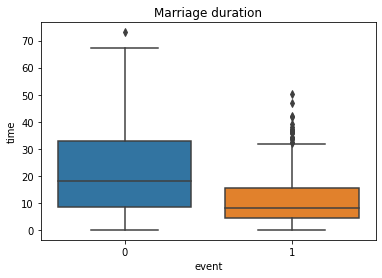

In [16]:
fig = sns.boxplot(data=df, x="event", y='time')
fig.set_title('Marriage duration')
sns.set(rc={'figure.figsize':(15,7)})

**Education and ethnicity variables vs event**

In [17]:
# let's start with education level
df['heduc'].value_counts()

1    1655
0    1288
2     428
Name: heduc, dtype: int64

Text(0.5, 1.0, 'Education level count')

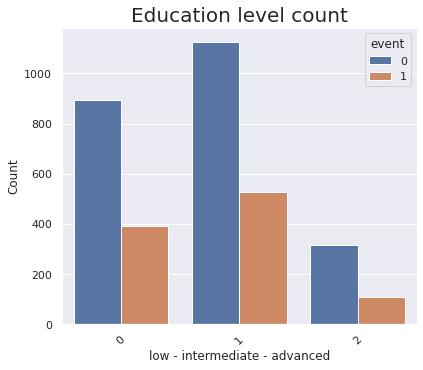

In [18]:
plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="heduc", data=df, 
              palette = None , hue = "event")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("low - intermediate - advanced", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Education level count", fontsize=20)

Just a small percentage of population has high level education

In [19]:
# now we analyze race
df['he_black'].value_counts()

0    2626
1     745
Name: he_black, dtype: int64

Black ethnicity males in the couples represent 22%. This is quite low, we will see in the survival analysis
if this variable has some influence despite a relatively small proportion. 

Text(0.5, 1.0, 'Black husband count')

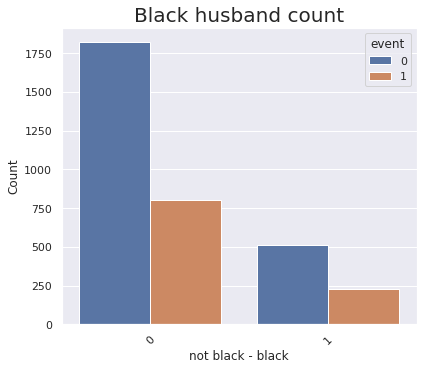

In [20]:
plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="he_black", data=df, 
              palette = None , hue = "event")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("not black - black", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Black husband count", fontsize=20)

For the couples whose husband is black, we observe a marriage duration that seems to be slightly
lower than for the other couples.

In [21]:
# mixed couples
df['mixed_couple'].value_counts()

0    2730
1     641
Name: mixed_couple, dtype: int64

Text(0.5, 1.0, 'Mixed couples count')

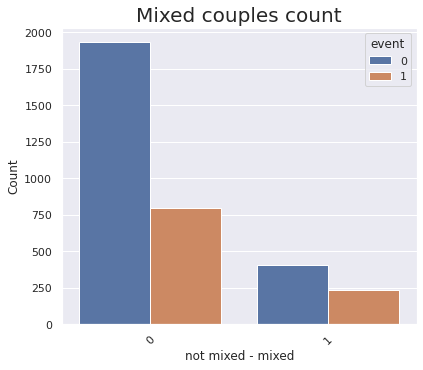

In [22]:
plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="mixed_couple", data=df, 
              palette = None , hue = "event")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("not mixed - mixed", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Mixed couples count", fontsize=20)

# 4. Survival analysis

In [23]:
# select time and event subsets
T = df["time"]
E = df["event"]

### Preliminary global analysis

<AxesSubplot: xlabel='timeline'>

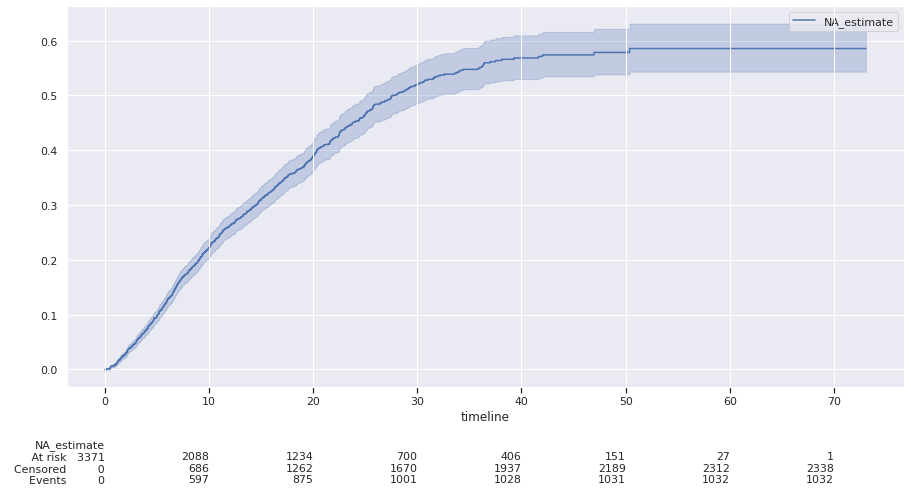

In [24]:
from lifelines import NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts

naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
ax=naf.plot_cumulative_hazard()
add_at_risk_counts(naf, ax=ax)

The cumulative hazard summary shows that more than 50% of the population could experience divorce after 30 years of marriage.
The cumulative hazard of marriage dissolution increases steeply
and stabilizes over time.

<AxesSubplot: xlabel='timeline'>

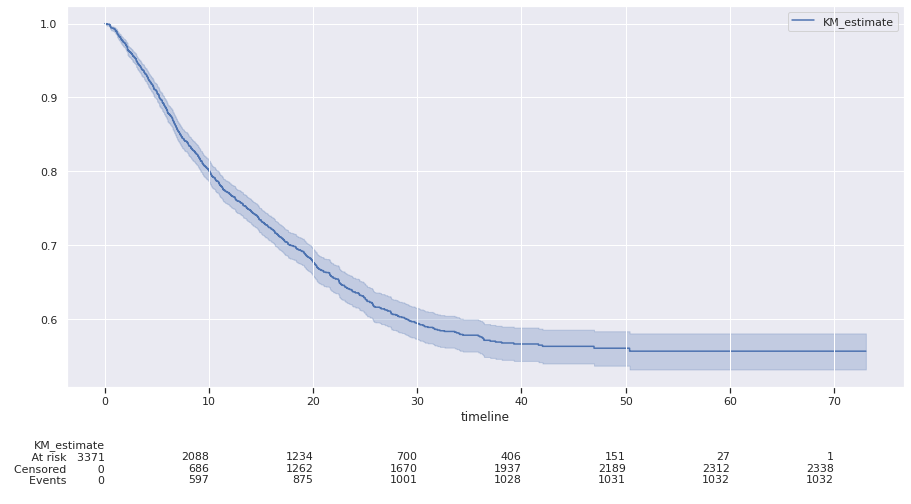

In [25]:
from lifelines import KaplanMeierFitter

# KM estimation
kmf= KaplanMeierFitter()
kmf.fit(T, event_observed=E)
ax=kmf.plot_survival_function(ci_show=True)
add_at_risk_counts(kmf, ax=ax)

The curve starts to stabilize once it
reaches 60 years.

**Husband is black variable**

In order to explore the influence of ethnic and social factors on marriage, we segregate the covariates based on race, to measure the effect of ethnicity on marriage longevity.

Text(0.5, 1.0, 'Cumulative hazard function of black/not black husband couples')

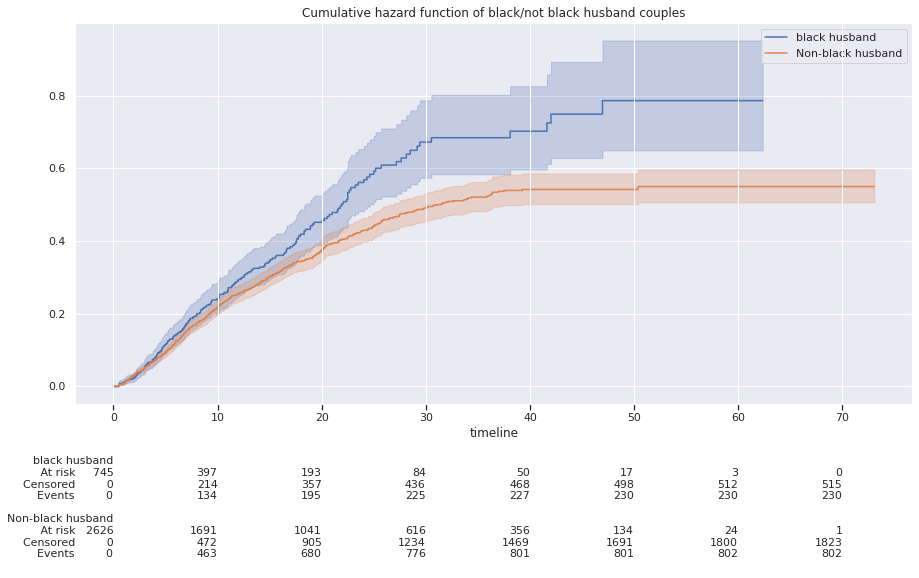

In [26]:
blk = (df["he_black"] == 1)

naf1=NelsonAalenFitter()
naf1.fit(T[blk], event_observed=E[blk], label="black husband")
ax = naf1.plot_cumulative_hazard(loc=slice(0, 80))

naf2=NelsonAalenFitter()
naf2.fit(T[~blk], event_observed=E[~blk], label="Non-black husband")
naf2.plot_cumulative_hazard(ax=ax, loc=slice(0, 80))

add_at_risk_counts(naf1,naf2, ax=ax)
plt.title("Cumulative hazard function of black/not black husband couples")

The cumulative hazard function shows that, after 30 years of marriage, 67% of couples headed by African American males are prone to get divorced, compared to only 50% of other ethnic groups.

The idea is to explore the time to divorce event depending on the education and ethnicity variables.
To do that, we will use the Kaplan-Meier estimator and the Logrank Test.

Text(0.5, 1.0, 'Lifespans of black/not black husband for all the couples')

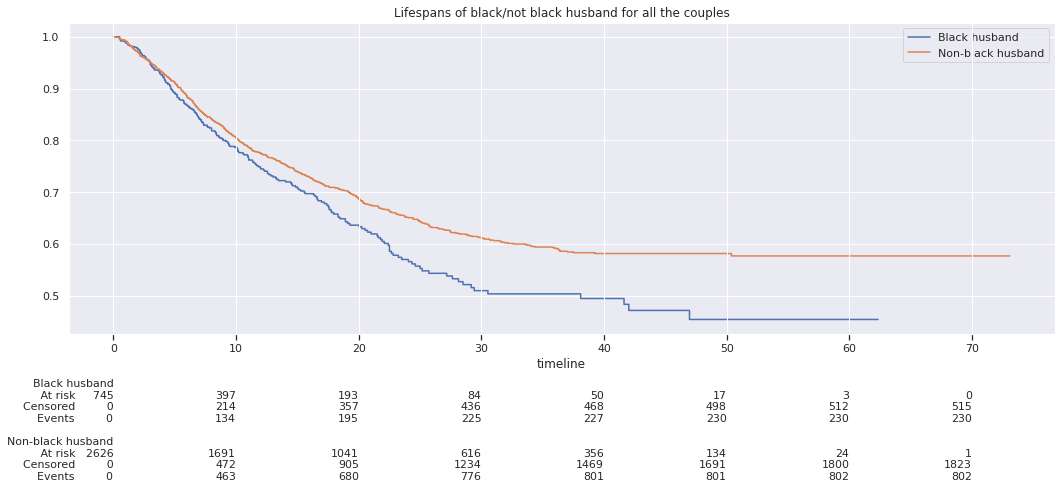

In [27]:
# KM estimation
ax = plt.subplot(111)

blk = (df["he_black"] == 1)

kmf_black = KaplanMeierFitter()
kmf_black.fit(T[blk], event_observed=E[blk], label="Black husband")
kmf_black.plot_survival_function(ax=ax,ci_show=False)


kmf_not_black = KaplanMeierFitter()
kmf_not_black.fit(T[~blk], event_observed=E[~blk], label="Non-black husband")
kmf_not_black.plot_survival_function(ax=ax,ci_show=False)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_black, kmf_not_black, ax=ax)
plt.tight_layout()

plt.title("Lifespans of black/not black husband for all the couples")

Figure shows that 50% of African American couples are still married as compared to 60% of couples from other ethnic groups during the same time period.

In [28]:
print('median survival time for black husband couple is: ', kmf_black.median_survival_time_, 'years')
print('median survival time for not black husband couple is: ', kmf_not_black.median_survival_time_, 'years')

median survival time for black husband couple is:  38.09149932861328 years
median survival time for not black husband couple is:  inf years


Another indication is the median survival probability that is 38.1 years for “husband is black” while it
is 'inf' for “husband is not black”. 'inf' means that the median value of survival probability of 50% is
NEVER reach. So, the case where “husband is not black” is more favorable wrt time to divorce event

From the scheme above, we can notice that the survival probability if “husband is black” in a couple is
lower than that “husband is not black”.

Text(0.5, 1.0, 'Lifespans of black/not black husband for only divorced couples')

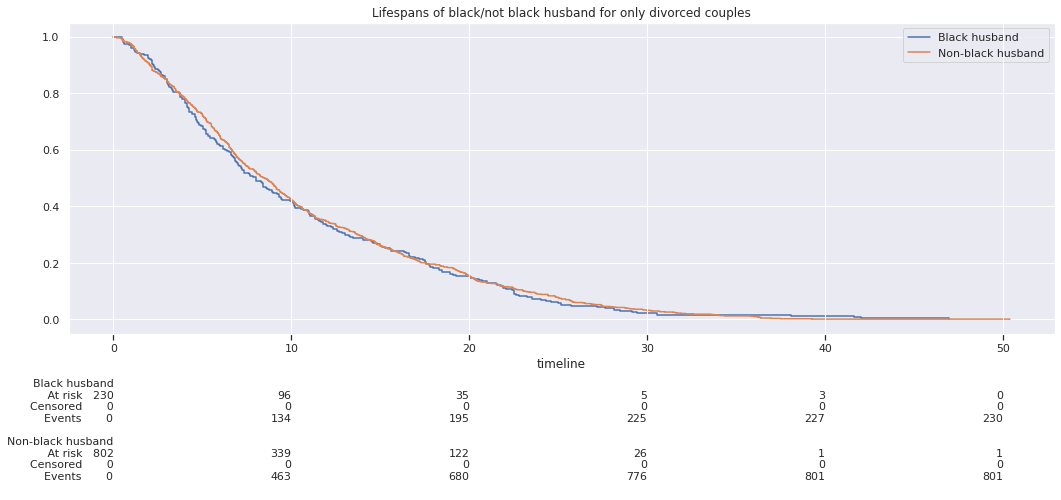

In [29]:
# now select just divorced couples
T_div = div["time"]
E_div = div["event"]

# KM estimation
ax = plt.subplot(111)

blk = (div["he_black"] == 1)

kmf_black = KaplanMeierFitter()
kmf_black.fit(T_div[blk], event_observed=E_div[blk], label="Black husband")
kmf_black.plot_survival_function(ax=ax,ci_show=False)


kmf_not_black = KaplanMeierFitter()
kmf_not_black.fit(T_div[~blk], event_observed=E_div[~blk], label="Non-black husband")
kmf_not_black.plot_survival_function(ax=ax,ci_show=False)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_black, kmf_not_black, ax=ax)
plt.tight_layout()

plt.title("Lifespans of black/not black husband for only divorced couples")

The two curves seems quite-similar, it's better to perform a log-rank test:

In [30]:
from lifelines.statistics import logrank_test

results = logrank_test(T_div[blk], T_div[~blk], E_div[blk], E_div[~blk], alpha=.05)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42

Alpha is the probability of rejecting the null hypothesis when it was in fact true.  Its value is often 5%.  
The p-value can be interpreted as the probability of getting a result that is as extreme or more extreme when the null hypothesis is true.
Basically, you decide on a value for alpha.  What probability of being wrong do you want to use?  What makes you comfortable? You then collect the data and calculate the p-value.  If the p-value is greater than alpha, you assume that the null hypothesis is true.  If the p-value is less than alpha, you assume that null hypothesis is false.

The p-value of the Logrank test (H0: groups are similar wrt survival) is small, but it's above significance level of 0.05 (5%), meaning the 2 groups are not different wrt the time to divorce, so H0 is accepted.

**“Couple is mixed ethnicity” variable**

To discover the covariate that is causing more hazard compared to others, the couples are broken down into two categories: same-race and mixed-race.

Text(0.5, 1.0, 'Cumulative hazard function of mixed/not mixed couples')

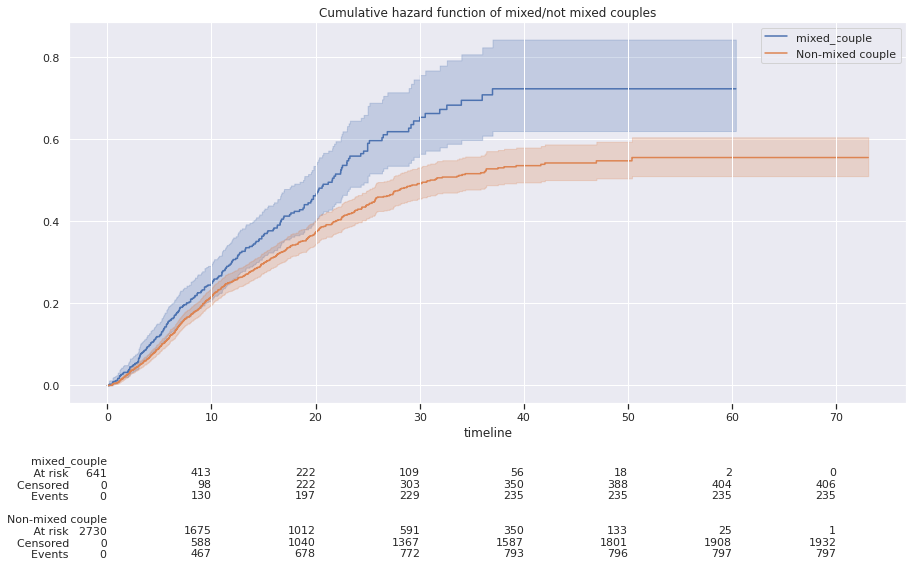

In [32]:
mix = (df["mixed_couple"] == 1)

naf1=NelsonAalenFitter()
naf1.fit(T[mix], event_observed=E[mix], label="mixed_couple")
ax = naf1.plot_cumulative_hazard(loc=slice(0, 80))

naf2=NelsonAalenFitter()
naf2.fit(T[~mix], event_observed=E[~mix], label="Non-mixed couple")
naf2.plot_cumulative_hazard(ax=ax, loc=slice(0, 80))


add_at_risk_counts(naf1,naf2,ax=ax)
plt.title("Cumulative hazard function of mixed/not mixed couples")

The analysis shows that after 30 years of marriage, 64% of mixed-race couples will get divorced, on the other hand, 49% of same-race couples will be divorced during the same time period.

Text(0.5, 1.0, 'Lifespans of all mixed/not mixed couples')

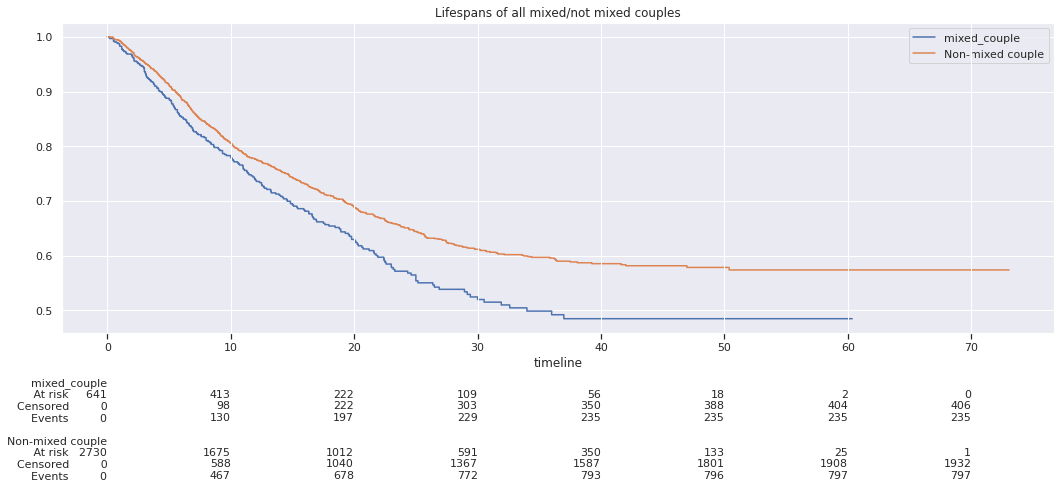

In [33]:
# KM estimation
ax = plt.subplot(111)

mix = (df["mixed_couple"] == 1)

kmf_mix = KaplanMeierFitter()
kmf_mix.fit(T[mix], event_observed=E[mix], label="mixed_couple")
kmf_mix.plot_survival_function(ax=ax,ci_show=False)


kmf_not_mix = KaplanMeierFitter()
kmf_not_mix.fit(T[~mix], event_observed=E[~mix], label="Non-mixed couple")
kmf_not_mix.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf_mix, kmf_not_mix, ax=ax)
plt.tight_layout()

plt.title("Lifespans of all mixed/not mixed couples")

Figure shows that 60% of same-race marriages are more likely
to survive over a period of 40 years. In contrast, only 49% of mixed-race marriages last over the same time period.

Same remark regarding the median survival probability as previously: the median value for survival
probability is 34 years, if the couple is of mixed ethnicity, while S=50% is never reached for a couple of
the same ethnicity. 

In [34]:
print('median survival time for mixed ethnicity couple is: ', kmf_mix.median_survival_time_, 'years')
print('median survival time for not mixed ethnicity couple is: ', kmf_not_mix.median_survival_time_, 'years')

median survival time for mixed ethnicity couple is:  33.99549865722656 years
median survival time for not mixed ethnicity couple is:  inf years


From the scheme above, we can notice that the survival probability if “couple is mixed ethnicity” is
lower than that “the couple is not of mixed ethnicity”.

Text(0.5, 1.0, 'Lifespans of mixed/not-mixed divorced couples')

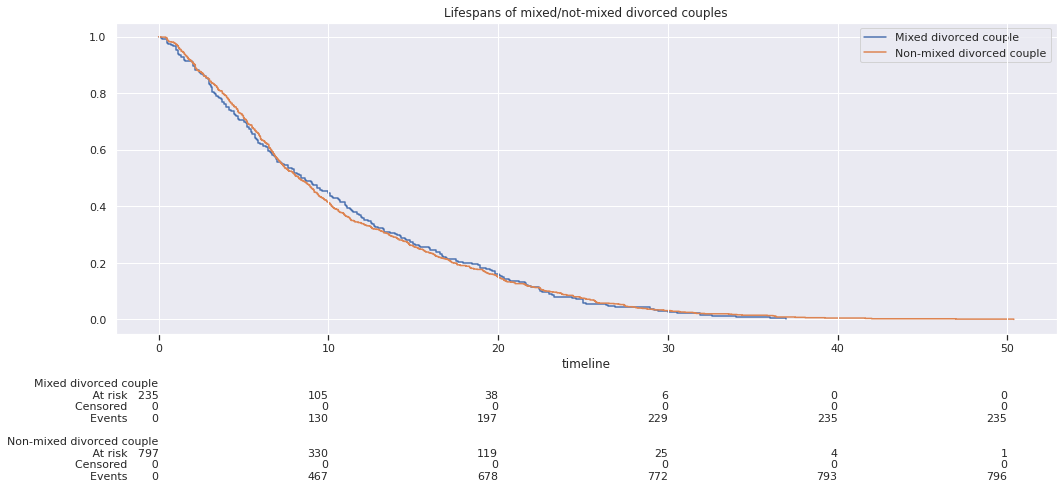

In [35]:
# KM estimation for divorced couples
ax = plt.subplot(111)

mix = (div["mixed_couple"] == 1)

kmf_mix = KaplanMeierFitter()
kmf_mix.fit(T_div[mix], event_observed=E_div[mix], label="Mixed divorced couple")
kmf_mix.plot_survival_function(ax=ax,ci_show=False)


kmf_not_mix = KaplanMeierFitter()
kmf_not_mix.fit(T_div[~mix], event_observed=E_div[~mix], label="Non-mixed divorced couple")
kmf_not_mix.plot_survival_function(ax=ax,ci_show=False)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_mix, kmf_not_mix, ax=ax)
plt.tight_layout()

plt.title("Lifespans of mixed/not-mixed divorced couples")

Again here curves seems quite similar, except at the beginning, so perform a log-rank test:

In [36]:
results = logrank_test(T_div[mix], T_div[~mix], E_div[mix], E_div[~mix], alpha=.05)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.88      0.18

The p-value of the Logrank test (H0: groups are similar wrt survival) is small, but above significance level of 0.05 (5%), meaning the 2 groups are not different wrt the time to divorce, so H0 is accepted.

**Husband education level**

Text(0.5, 1.0, 'Lifespans of all education levels of the husband')

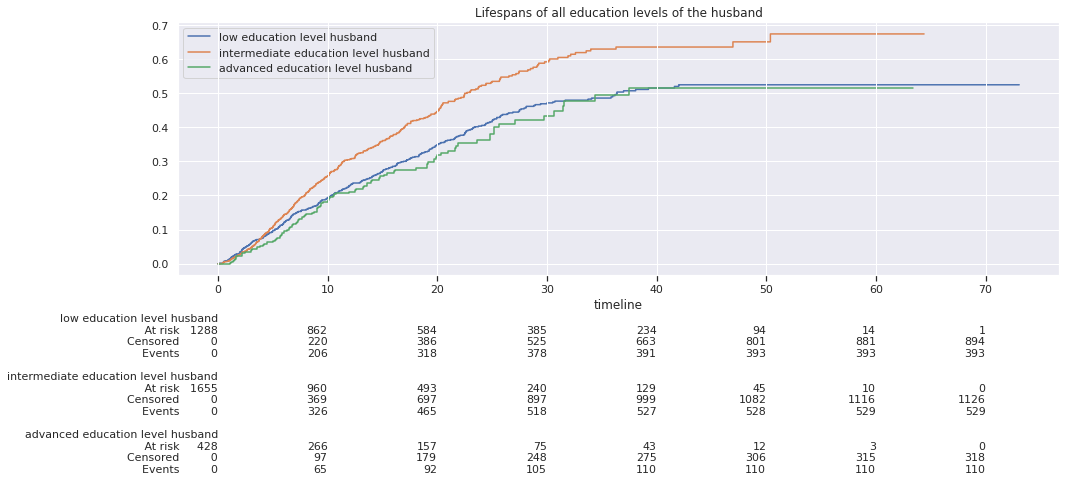

In [37]:
# hazard cumulative function

ax = plt.subplot(111)

edu0 = (df["heduc"] == 0)

naf_edu0= NelsonAalenFitter()
naf_edu0.fit(T[edu0], event_observed=E[edu0], label="low education level husband")
naf_edu0.plot_cumulative_hazard(ax=ax, loc=slice(0, 80),ci_show=False)

edu1 = (df["heduc"] == 1)

naf_edu1= NelsonAalenFitter()
naf_edu1.fit(T[edu1], event_observed=E[edu1], label="intermediate education level husband")
naf_edu1.plot_cumulative_hazard(ax=ax, loc=slice(0, 80),ci_show=False)

edu2 = (df["heduc"] == 2)

naf_edu2= NelsonAalenFitter()
naf_edu2.fit(T[edu2], event_observed=E[edu2], label="advanced education level husband")
naf_edu2.plot_cumulative_hazard(ax=ax, loc=slice(0, 80),ci_show=False)

add_at_risk_counts(naf_edu0, naf_edu1, naf_edu2, ax=ax)
plt.tight_layout()

plt.title("Lifespans of all education levels of the husband")

Text(0.5, 1.0, 'Lifespans of all education levels of the husband')

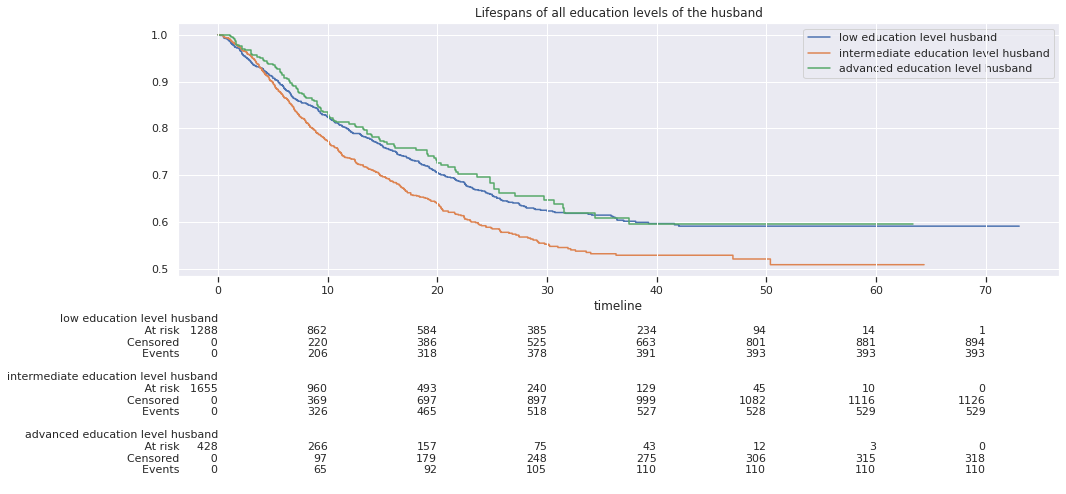

In [42]:
# KM estimation
ax = plt.subplot(111)

edu0 = (df["heduc"] == 0)

kmf_edu0= KaplanMeierFitter()
kmf_edu0.fit(T[edu0], event_observed=E[edu0], label="low education level husband")
kmf_edu0.plot_survival_function(ax=ax,ci_show=False)

edu1 = (df['heduc']==1)

kmf_edu1 = KaplanMeierFitter()
kmf_edu1.fit(T[edu1], event_observed=E[edu1], label="intermediate education level husband")
kmf_edu1.plot_survival_function(ax=ax,ci_show=False)

edu2 = (df['heduc']==2)

kmf_edu2 = KaplanMeierFitter()
kmf_edu2.fit(T[edu2], event_observed=E[edu2], label="advanced education level husband")
kmf_edu2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf_edu0, kmf_edu1, kmf_edu2, ax=ax)
plt.tight_layout()

plt.title("Lifespans of all education levels of the husband")

Our model predicts that people who have
obtained a high level of education (60%) and elementary education (60%) will have the longest marriage survival time compared to couples who have completed high school (55%) stayed together after 40 years.

The median value of 50% is never reached for any of the education level classes

In [43]:
print('median survival time for low education level husband is: ', kmf_edu0.median_survival_time_, 'years')
print('median survival time for intermediate education level husband is: ', kmf_edu1.median_survival_time_, 'years')
print('median survival time for advanced education level husband is: ', kmf_edu2.median_survival_time_, 'years')

median survival time for low education level husband is:  inf years
median survival time for intermediate education level husband is:  inf years
median survival time for advanced education level husband is:  inf years


Regarding the influence of the level of education of the husband in the couple, the class corresponding
to “12-15y” has a lower survival probability. This may come from the fact that this group has the largest proportion in the dataset. This does not bring really any valuable information.
So, a more refined analysis is required here.

Text(0.5, 1.0, 'Lifespans of education levels for all divorced husbands')

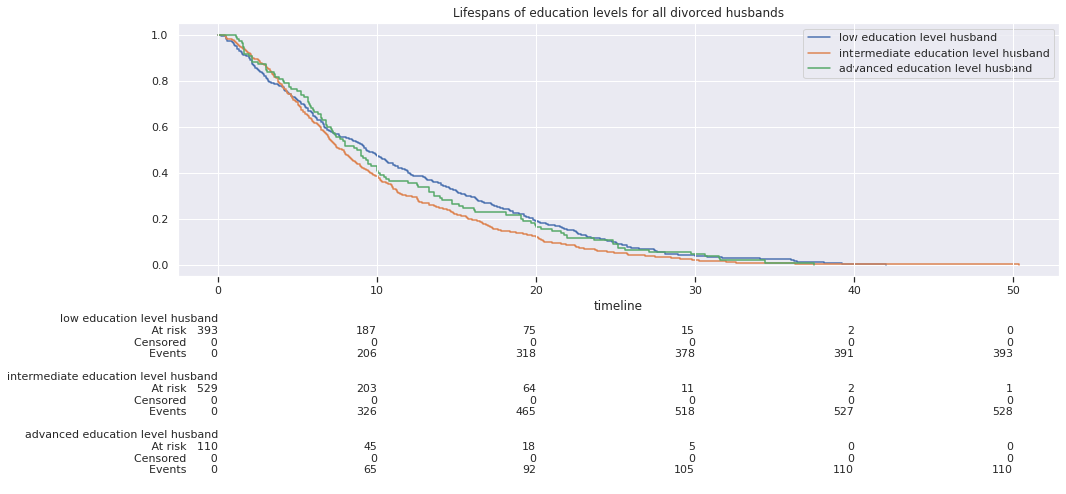

In [44]:
# KM estimation of divorced couples
ax = plt.subplot(111)

edu0 = (div["heduc"] == 0)

kmf_edu0= KaplanMeierFitter()
kmf_edu0.fit(T_div[edu0], event_observed=E_div[edu0], label="low education level husband")
kmf_edu0.plot_survival_function(ax=ax,ci_show=False)

edu1 = (div['heduc']==1)

kmf_edu1 = KaplanMeierFitter()
kmf_edu1.fit(T_div[edu1], event_observed=E_div[edu1], label="intermediate education level husband")
kmf_edu1.plot_survival_function(ax=ax,ci_show=False)

edu2 = (div['heduc']==2)

kmf_edu2 = KaplanMeierFitter()
kmf_edu2.fit(T_div[edu2], event_observed=E_div[edu2], label="advanced education level husband")
kmf_edu2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf_edu0, kmf_edu1, kmf_edu2, ax=ax)
plt.tight_layout()

plt.title("Lifespans of education levels for all divorced husbands")

In [45]:
from lifelines.statistics import pairwise_logrank_test
# Helper function for printing out Log-rank test results
def print_logrank(col):
    log_rank = pairwise_logrank_test(T_div, div[col], E_div, alpha=.05)
    return log_rank.summary

print_logrank('heduc')

test_statistic         p  -log2(p)
0 1        9.950378  0.001608  9.280370
  2        0.335557  0.562405  0.830318
1 2        2.210744  0.137053  2.867199

The p-value of the Logrank test (H0: groups are similar wrt survival) is:
- really small for comparison betweenn group 0 and 1, below significance level of 0.05 (5%), meaning the groups are different wrt the time to divorce, so H0 is accepted.
- above significance level of 0,05 for the other two comparisons, so H0 is rejected for both.

**Stratified test of husband education level and ethnicity (husband is black)**

It may be interesting to combine education level analysis with the ethnicity variable. 

Text(0.5, 1.0, 'Lifespans of all education levels of the black husband')

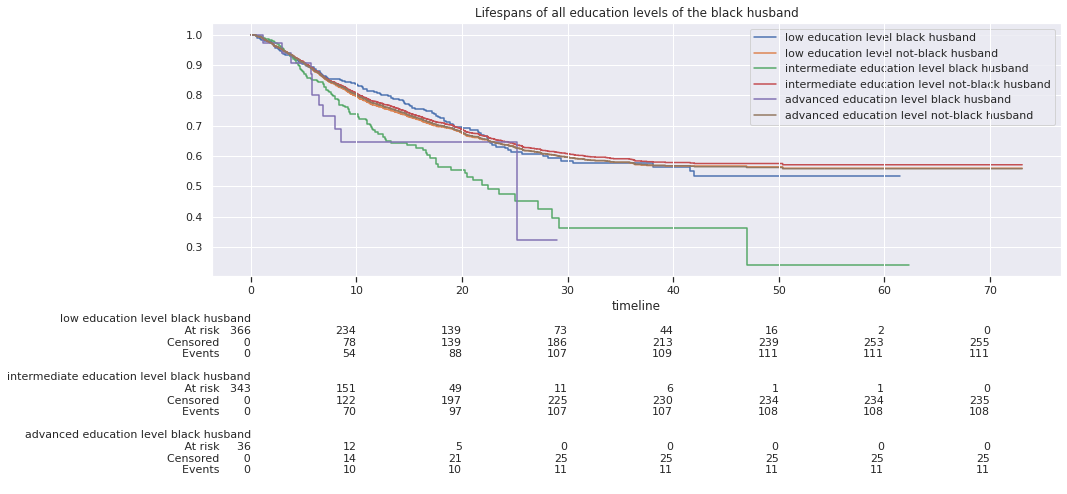

In [46]:
# KM estimation
ax = plt.subplot(111)

# subset of low education level black husband
edu0_blk = ((df["heduc"] == 0) & (df['he_black']==1))

kmf_edu0_blk= KaplanMeierFitter()
kmf_edu0_blk.fit(T[edu0_blk], event_observed=E[edu0_blk], label="low education level black husband")
kmf_edu0_blk.plot_survival_function(ax=ax,ci_show=False)

# subset of low education level not black husband
kmf_edu0_not_blk = KaplanMeierFitter()
kmf_edu0_not_blk.fit(T[~edu0_blk], event_observed=E[~edu0_blk], label="low education level not-black husband")
kmf_edu0_not_blk.plot_survival_function(ax=ax,ci_show=False)

# subset of intermediate education level black husband
edu1_blk = ((df['heduc']==1) & (df['he_black']==1))

kmf_edu1_blk = KaplanMeierFitter()
kmf_edu1_blk.fit(T[edu1_blk], event_observed=E[edu1_blk], label="intermediate education level black husband")
kmf_edu1_blk.plot_survival_function(ax=ax,ci_show=False)
                     
# subset of intermediate education level not black husband
kmf_edu1_not_blk = KaplanMeierFitter()
kmf_edu1_not_blk.fit(T[~edu1_blk], event_observed=E[~edu1_blk], label="intermediate education level not-black husband")
kmf_edu1_not_blk.plot_survival_function(ax=ax,ci_show=False)

# subset of advanced education level black husband
edu2_blk = ((df['heduc']==2) & (df['he_black']==1))

kmf_edu2_blk = KaplanMeierFitter()
kmf_edu2_blk.fit(T[edu2_blk], event_observed=E[edu2_blk], label="advanced education level black husband")
kmf_edu2_blk.plot_survival_function(ax=ax,ci_show=False)
                     
# subset of advanced education level not black husband
kmf_edu2_not_blk = KaplanMeierFitter()
kmf_edu2_not_blk.fit(T[~edu2_blk], event_observed=E[~edu2_blk], label="advanced education level not-black husband")
kmf_edu2_not_blk.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf_edu0_blk, kmf_edu1_blk, kmf_edu2_blk, ax=ax)
plt.tight_layout()

plt.title("Lifespans of all education levels of the black husband")

We can notice 2 things:
- The couples, whose husband is black, have always a lower survival probability than the others,
whatever the level of education is.
Notice: “husband is black” covers both cases where husband and wife are black (couple is NOT
mixed ethnicity) or only the husband is black (couple is mixed ethnicity)
- The higher the education level, the bigger the difference in survival probability

**Stratified test of husband education level and ethnicity (couple is mixed ethnicity)**

Text(0.5, 1.0, 'Lifespans of all education levels for all the mixed/not-mixed couples')

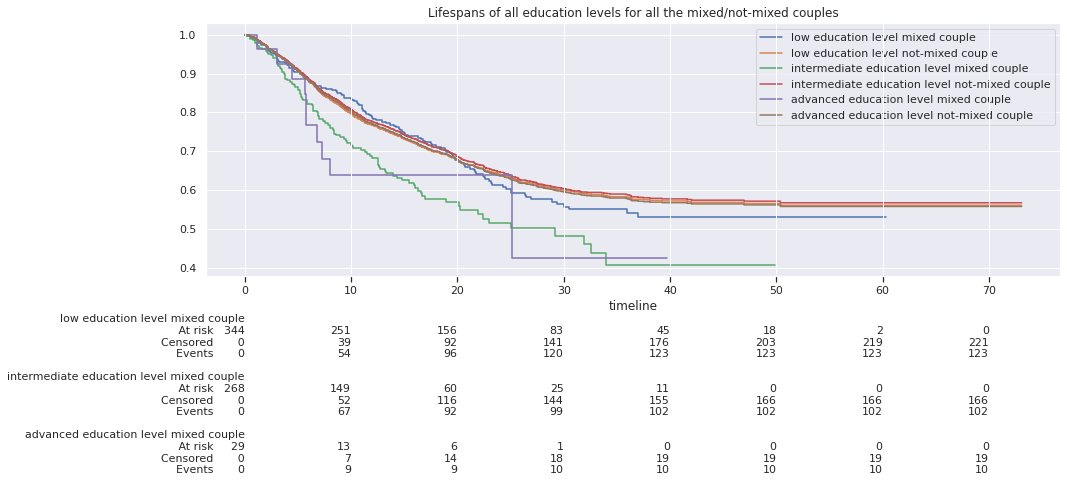

In [47]:
# KM estimation
ax = plt.subplot(111)

# subset of low education level black husband
edu0_mix = ((df["heduc"] == 0) & (df['mixed_couple']==1))

kmf_edu0_mix= KaplanMeierFitter()
kmf_edu0_mix.fit(T[edu0_mix], event_observed=E[edu0_mix], label="low education level mixed couple")
kmf_edu0_mix.plot_survival_function(ax=ax,ci_show=False)

# subset of low education level not black husband
kmf_edu0_not_mix = KaplanMeierFitter()
kmf_edu0_not_mix.fit(T[~edu0_mix], event_observed=E[~edu0_mix], label="low education level not-mixed couple")
kmf_edu0_not_mix.plot_survival_function(ax=ax,ci_show=False)

# subset of intermediate education level black husband
edu1_mix = ((df['heduc']==1) & (df['mixed_couple']==1))

kmf_edu1_mix = KaplanMeierFitter()
kmf_edu1_mix.fit(T[edu1_mix], event_observed=E[edu1_mix], label="intermediate education level mixed couple")
kmf_edu1_mix.plot_survival_function(ax=ax,ci_show=False)
                     
# subset of intermediate education level not black husband
kmf_edu1_not_mix = KaplanMeierFitter()
kmf_edu1_not_mix.fit(T[~edu1_mix], event_observed=E[~edu1_mix], label="intermediate education level not-mixed couple")
kmf_edu1_not_mix.plot_survival_function(ax=ax,ci_show=False)

# subset of advanced education level black husband
edu2_mix = ((df['heduc']==2) & (df['mixed_couple']==1))

kmf_edu2_mix = KaplanMeierFitter()
kmf_edu2_mix.fit(T[edu2_mix], event_observed=E[edu2_mix], label="advanced education level mixed couple")
kmf_edu2_mix.plot_survival_function(ax=ax,ci_show=False)
                     
# subset of advanced education level not black husband
kmf_edu2_not_mix = KaplanMeierFitter()
kmf_edu2_not_mix.fit(T[~edu2_mix], event_observed=E[~edu2_mix], label="advanced education level not-mixed couple")
kmf_edu2_not_mix.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf_edu0_mix, kmf_edu1_mix, kmf_edu2_mix, ax=ax)
plt.tight_layout()

plt.title("Lifespans of all education levels for all the mixed/not-mixed couples")

The analysis of the “mixed ethnicity couple” variable brings a similar observation as for the “black
husband ethnicity” variable: the mixed ethnicity couples have always a lower survival probability than
the others, whatever the level of education is.
Notice: in both last two cases, the number of samples where education level =2 and ethnicity variable
= true (black or mixed) is statistically low. This may lead to a bias in the results.

### Cox regression

In [48]:
df=df.drop('id', axis=1)

Thanks to the COX regression, we may add some risk information on the time to divorce probability,
from the education level and ethnicity variables

In [49]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='time', event_col='event')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3371 total observations, 2339 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3371
number of events observed = 1032
   partial log-likelihood = -7834.90
         time fit was run = 2023-01-26 18:18:06 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
heduc          0.09       1.10       0.05             0.00             0.19                 1.00                 1.21
he_black       0.18       1.20       0.08             0.03             0.34                 1.03                 1.40
mixed_couple   0.23       1.26       0.08             0.07             0.38                 1.08                 1.47

               cmp to    z      p   -log2(p)
covariate                                   
heduc            0.00 2.00   0.05       4.45
he_black         0.00 2.30   0.02       5.56
mixed_couple     0.00 2.89 <0.005       8.03
---
Concordance = 0.52
Partial AIC = 15675.80
log-likelihood ratio test = 18.81 on 3 df
-log2(p) of ll-ratio test = 11.71

Recall, in the Cox proportional hazard model, a higher hazard means more at risk of the event occurring.
Hazards can change over time, but their ratio between levels remains a constant.

The quantities exp(coeff=beta) are called hazard ratios (HR). A value of beta greater than zero indicates that, as the value of the covariate increases, the event hazard increases and thus the length of survival decreases.

**Wald test (Z)**
statistical significance. The column marked “z” gives the Wald statistic value. It corresponds to the ratio of each regression coefficient to its standard error (z = coef/se(coef)). The wald statistic evaluates, whether the beta (β) coefficient of a given variable is statistically significantly different from 0

**log-likelihood ratio test**
The likelihood ratio test (LRT) is a statistical test of the goodness-of-fit between two models. A relatively more complex model is compared to a simpler model to see if it fits a particular dataset significantly better. If so, the additional parameters of the more complex model are often used in subsequent analyses.
The LRT begins with a comparison of the likelihood scores of the two models:

LR = 2*(lnL1-lnL2)

This LRT statistic approximately follows a chi-square distribution. To determine if the difference in likelihood scores among the two models is statistically significant, we next must consider the degrees of freedom. In the LRT, degrees of freedom is equal to the number of additional parameters in the more complex model. Using this information we can then determine the critical value of the test statistic from standard statistical tables. So if the critical value of chi2, for that p-value and covariate, is greater than LR then H0 is rejected, else is accepted, that is: covariate has a great impact (statistically) on the model.

From the COX regression results, we can notice the following:
- The 3 p-values are below a 0.05 significance level for H0: beta=0. This means that the 3 variables have a significant impact on the survival probability
- However, the “mixed couple” factor is the most significant by an order of magnitude vs the 2 others (<0.005 vs 0.02 and 0.05)
- It also has the highest risk (1.26) leading to the lowest survival probability (lowest time to divorce)
- Higher to lower risk: mixed > black > education level

These results confirm quantitatively the observations from the schemes from the previous section:
- Ethnicity variables (“husband is black” or “couple is mixed”) bring a higher risk to the time to divorce event
- The higher the education level, the higher the risk 

An alternative way to view the coefficients and their ranges is to visualize it using the plot method in CPH, that in turn, will produce a clearer image as to which particular covariate affects the dataset the most and in what range does it fall.

<AxesSubplot: xlabel='log(HR) (95% CI)'>

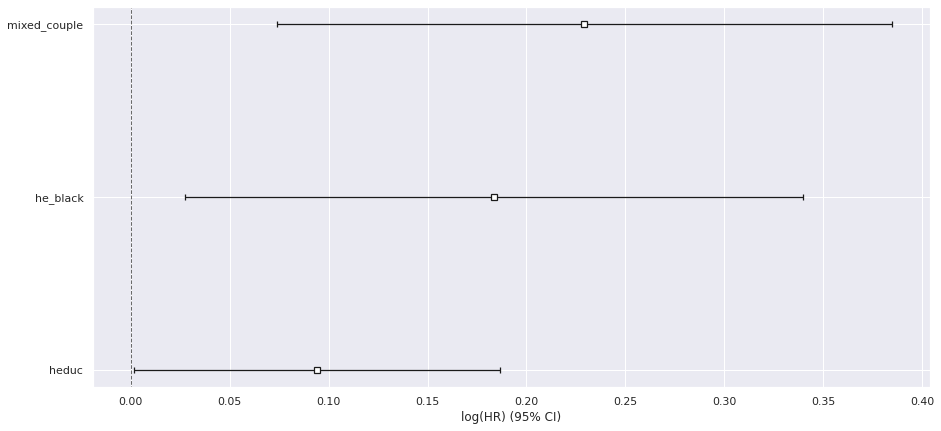

In [50]:
# plotting coefficients
cph.plot()

## Predictions

Predict whether couples are about to divorce and which are the most important features to get that prediction right.
So i'm evaluating machine learning models through the concordance index.

In [51]:
X = df.drop(['time', 'event'], axis=1) # features
T = df['time'] # time
E = df['event'] # divorce

# Build train and test sets
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.3, random_state=0)
T_train, T_val = train_test_split(T, test_size=0.3, random_state=0)
E_train, E_val = train_test_split(E, test_size=0.3, random_state=0)
print(E_train.shape, E_val.shape)

(2359,) (1012,)


Let's compare the performance of three different random forest models to make the divorce predictions:

- Random forest classifier

- Random forest regressor

- Random survival forest

Concordance index of Random forest classifier: train: 0.529 valid: 0.535


<AxesSubplot: >

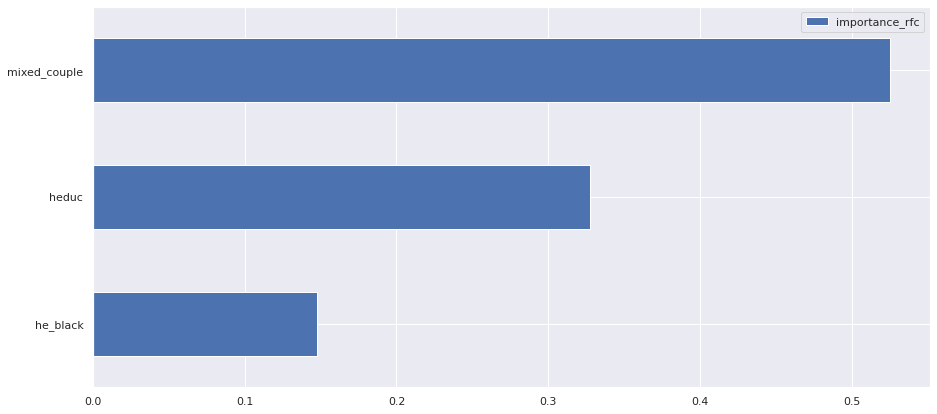

In [52]:
from sklearn.ensemble import RandomForestClassifier
from lifelines.utils import concordance_index

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, E_train)

ci_rfc_trn = concordance_index(T_train, rfc.predict_proba(X_train)[:,0], E_train)
ci_rfc_val = concordance_index(T_val, rfc.predict_proba(X_val)[:,0], E_val)

print(f'Concordance index of Random forest classifier: train: {ci_rfc_trn:.3f} valid: {ci_rfc_val:.3f}')

# feature importance
fi_rfc = rfc.feature_importances_
rfi_rfc =  np.abs(fi_rfc)/np.sum(np.abs(fi_rfc))
lab = X_train.columns
df_fi_rfc = pd.DataFrame(data={'importance_rfc': rfi_rfc}, index=lab)
df_fi_rfc = df_fi_rfc.sort_values(by='importance_rfc', ascending=True)[:]
df_fi_rfc.plot.barh(y='importance_rfc')

and the most important feature seems to be mixed_couple

c-index of Random forest regressor: train: 0.541 valid: 0.535


<AxesSubplot: >

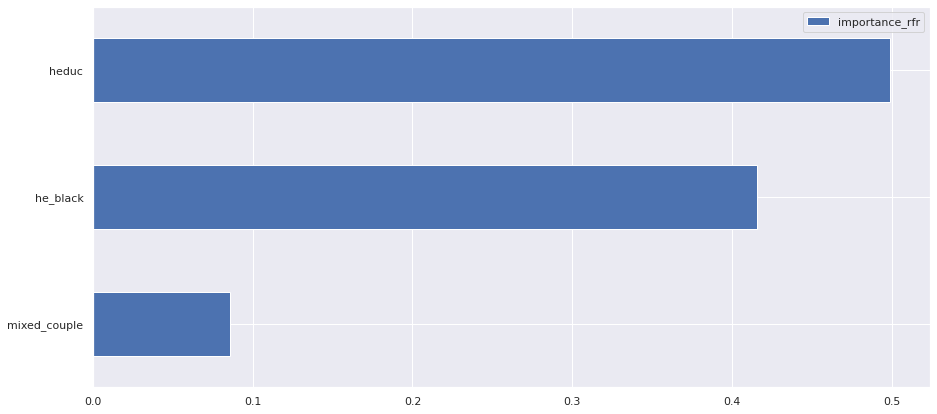

In [53]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, T_train)

ci_rfr_trn = concordance_index(T_train, rfr.predict(X_train), E_train)
ci_rfr_val = concordance_index(T_val, rfr.predict(X_val), E_val)

print(f'c-index of Random forest regressor: train: {ci_rfr_trn:.3f} valid: {ci_rfr_val:.3f}')

# feature importance
fi_rfr = rfr.feature_importances_
rfi_rfr =  np.abs(fi_rfr)/np.sum(np.abs(fi_rfr))
lab = X_train.columns
df_fi_rfr = pd.DataFrame(data={'importance_rfr': rfi_rfr}, index=lab)
df_fi_rfr = df_fi_rfr.sort_values(by='importance_rfr', ascending=True)[:]
df_fi_rfr.plot.barh(y='importance_rfr')

and the most important feature seems to be heduc

c-index of Random survival forest: train: 0.541, valid: 0.549


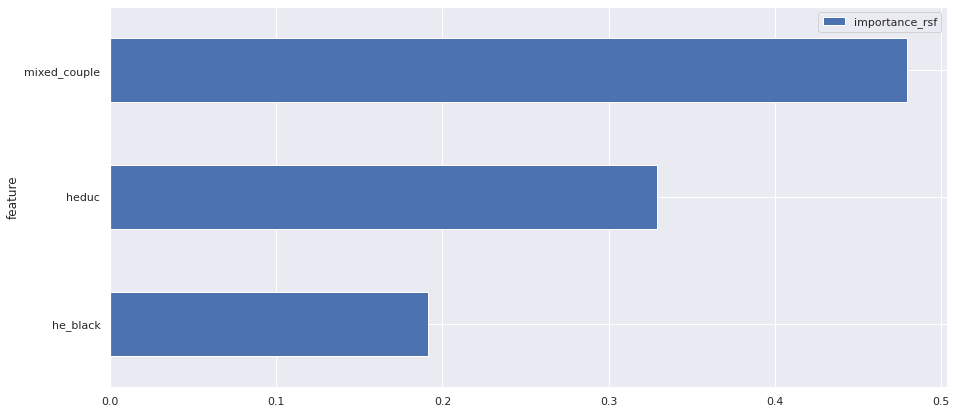

In [54]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=100)
rsf.fit(X_train, T_train, E_train, seed=0)
ci_rsf_trn = concordance_index(T_train, -rsf.predict_risk(X_train), E_train)
ci_rsf_val = concordance_index(T_val, -rsf.predict_risk(X_val), E_val)

print(f'c-index of Random survival forest: train: {ci_rsf_trn:.3f}, valid: {ci_rsf_val:.3f}')

# feature importance
fi_rsf = rsf.variable_importance_
rfi_rsf =  np.abs(fi_rsf)/np.sum(np.abs(fi_rsf))
lab = X_train.columns
df_fi_rsf = pd.DataFrame({'feature': lab, 'importance_rsf': rfi_rsf}).set_index('feature')
df_fi_rsf = df_fi_rsf.sort_values(by='importance_rsf', ascending=True)[:]
df_fi_rsf.plot.barh(y='importance_rsf');

and the most important feature seems to be mixed_couple again

Random survival forest outperforms both random forest classifier and random forest regressor in all of the considered cases.

Random forest classifier is only using the available 'event' information. Random forest regressor is only using the available 'time' information. However, random survival forest is simultaneously using both the event information and the time information.